In [1]:
%load_ext autoreload
%autoreload 2

from math import pi

import jax
from jax import random
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from scipy.optimize import minimize_scalar, root_scalar

from diffbank.bank import Bank
from diffbank.constants import C, G, MSUN
from diffbank.metric import get_density
from diffbank.noise import Sn_aLIGO
from diffbank.utils import get_m1_m2_sampler, est_ratio_max
from diffbank.waveforms.taylorf2reducedspin import Psi, amp, get_th_boundary_interps

Setup

In [2]:
key = random.PRNGKey(100)

minimum_match = 0.95
m_star = 1 - minimum_match
eta_star = 0.99
fs = jnp.linspace(20.0, 2000.0, 1000)
f_0 = 20.0  # Hz
m_range = (2.0 * MSUN, 5.0 * MSUN)
chi_range = (-0.98, 0.98)

th0_range, th3_interp_low, th3_interp_high = get_th_boundary_interps(*m_range, f_0)
th3_range = (th3_interp_low(th0_range[0]), th3_interp_low(th0_range[1]))
th3S_max = (
    113
    * chi_range[1]
    / (
        192
        * f_0 ** (2 / 3)
        * pi ** (2 / 3)
        * (
            m_range[0] ** 2
            / (m_range[0] + m_range[0]) ** (4 / 3)
            * (G / C ** 3) ** (2 / 3)
        )
    )
)
th3S_range = (-th3S_max, th3S_max)


@jax.jit
def sampler_1(key):
    return random.uniform(
        key,
        (3,),
        minval=jnp.array([th0_range[0], th3_range[0], th3S_range[0]]),
        maxval=jnp.array([th0_range[1], th3_range[1], th3S_range[1]]),
    )


@jax.jit
def is_in_bounds(theta):
    chi = 48 * pi * theta[..., 2] / (113 * theta[..., 1])
    return jnp.logical_and(
        theta[..., 1] > th3_interp_low(theta[..., 0]),
        jnp.logical_and(
            theta[..., 1] < th3_interp_high(theta[..., 0]),
            jnp.abs(chi) < chi_range[1],
        ),
    )


@jax.jit
def sample_1(key):
    cond_fun = lambda val: jnp.logical_not(is_in_bounds(val[1]))

    def body_fun(val):
        key = val[0]
        key, subkey = random.split(key)
        return (key, sampler_1(subkey))

    key, subkey = random.split(key)
    init_val = (key, sampler_1(subkey))
    return jax.lax.while_loop(cond_fun, body_fun, init_val)[1]


def sampler(key, n):
    return jax.lax.map(sample_1, random.split(key, n))


bank_r = Bank(amp, Psi, fs, Sn_aLIGO, m_star, eta_star, sampler, name="tf2rs-random")
bank_s = Bank(
    amp, Psi, fs, Sn_aLIGO, m_star, eta_star, sampler, name="tf2rs-stochastic"
)

# Max density point
ratio_max = bank_r.density_fun(jnp.stack([th0_range[1], th3_range[1], th3S_range[0]]))
bank_r.ratio_max = ratio_max
bank_s.ratio_max = ratio_max

Check sampler

Text(0, 0.5, '$\\theta_3$')

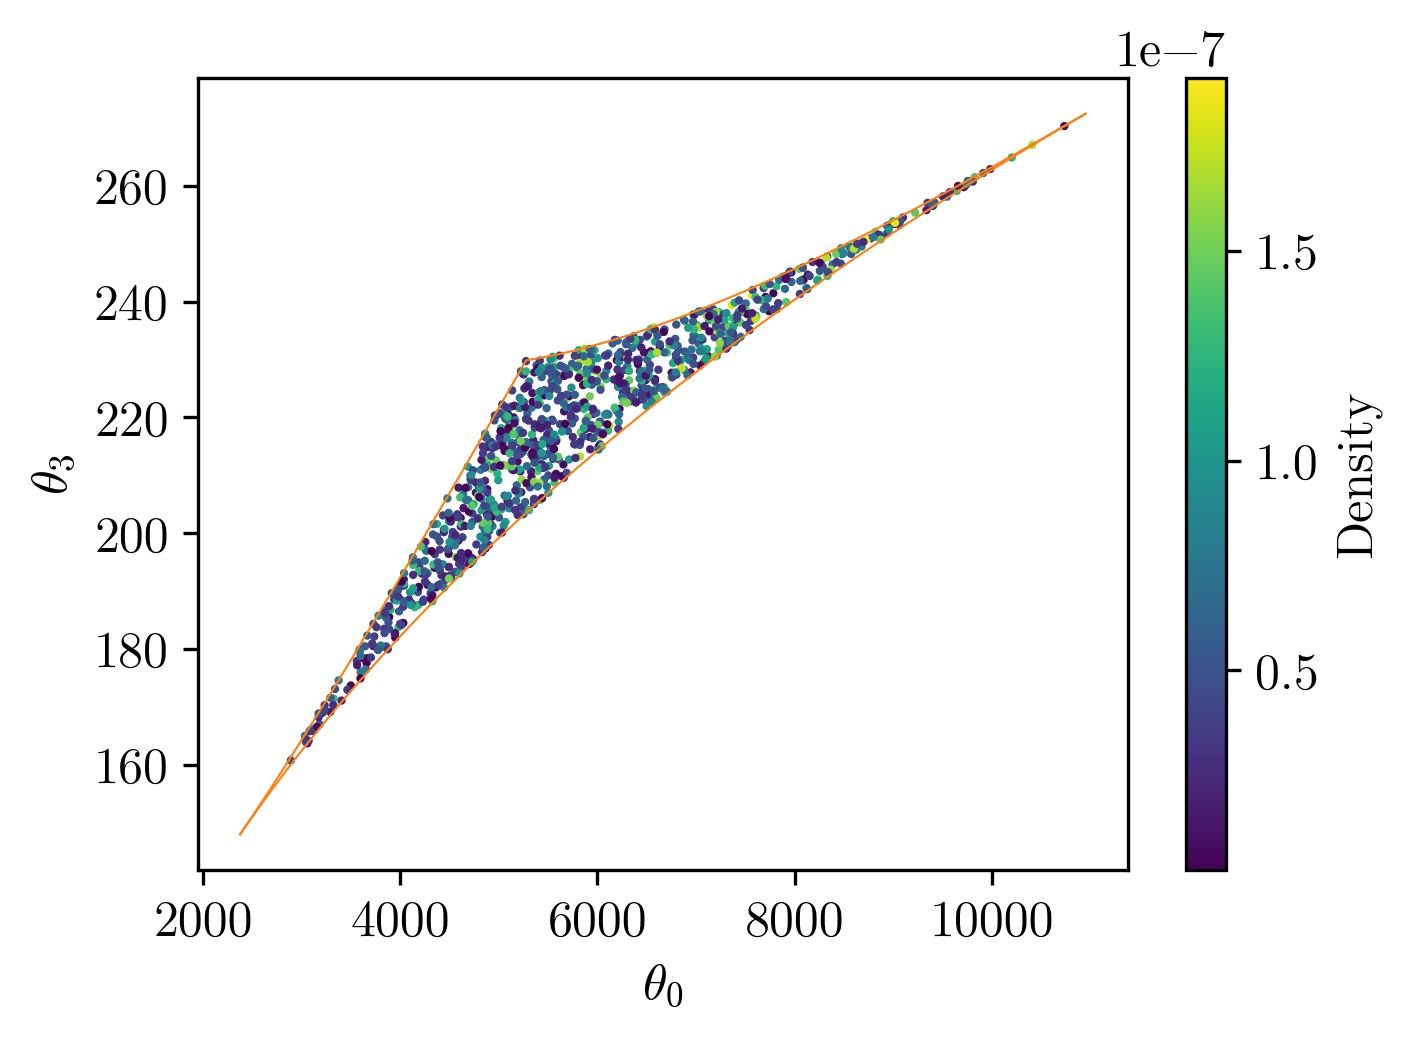

In [4]:
key, subkey = random.split(key)
thetas = sampler(subkey, 1000)
plt.scatter(*thetas.T[:-1], s=1, c=jax.lax.map(bank_r.density_fun, thetas))
plt.colorbar(label="Density")

th0s = jnp.linspace(th0_range[0], th0_range[1], 500)
plt.plot(th0s, th3_interp_low(th0s), "C1", linewidth=0.5)
plt.plot(th0s, th3_interp_high(th0s), "C1", linewidth=0.5)

plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_3$")

Random bank

In [ ]:
key, subkey = random.split(key)
bank_r.fill_bank(subkey, "random", n_eff=1000)

In [9]:
key, subkey = random.split(key)
bank_r.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
bank_r.save("banks/")

Stochastic bank

In [7]:
key, subkey = random.split(key)
bank_s.fill_bank(subkey, "stochastic", n_eff=1000)

  0%|          | 0/990 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
key, subkey = random.split(key)
bank_s.calc_bank_effectualness(subkey, 500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [10]:
bank_s.save("banks/")

Compare

In [3]:
bank_r = Bank.load("banks/tf2rs-random.npz", amp, Psi, Sn_aLIGO, sampler)

/Users/acoogan/.pyenv/versions/3.9.1/envs/tbanks-3.9.1/lib/python3.9/site-packages/matplotlib/axes/_axes.py:6665: RuntimeWarning: invalid value encountered in multiply
  tops = (tops * np.diff(bins))[:, slc].cumsum(axis=1)[:, slc]


Text(0.5, 1.0, 'TaylorF2ReducedSpin')

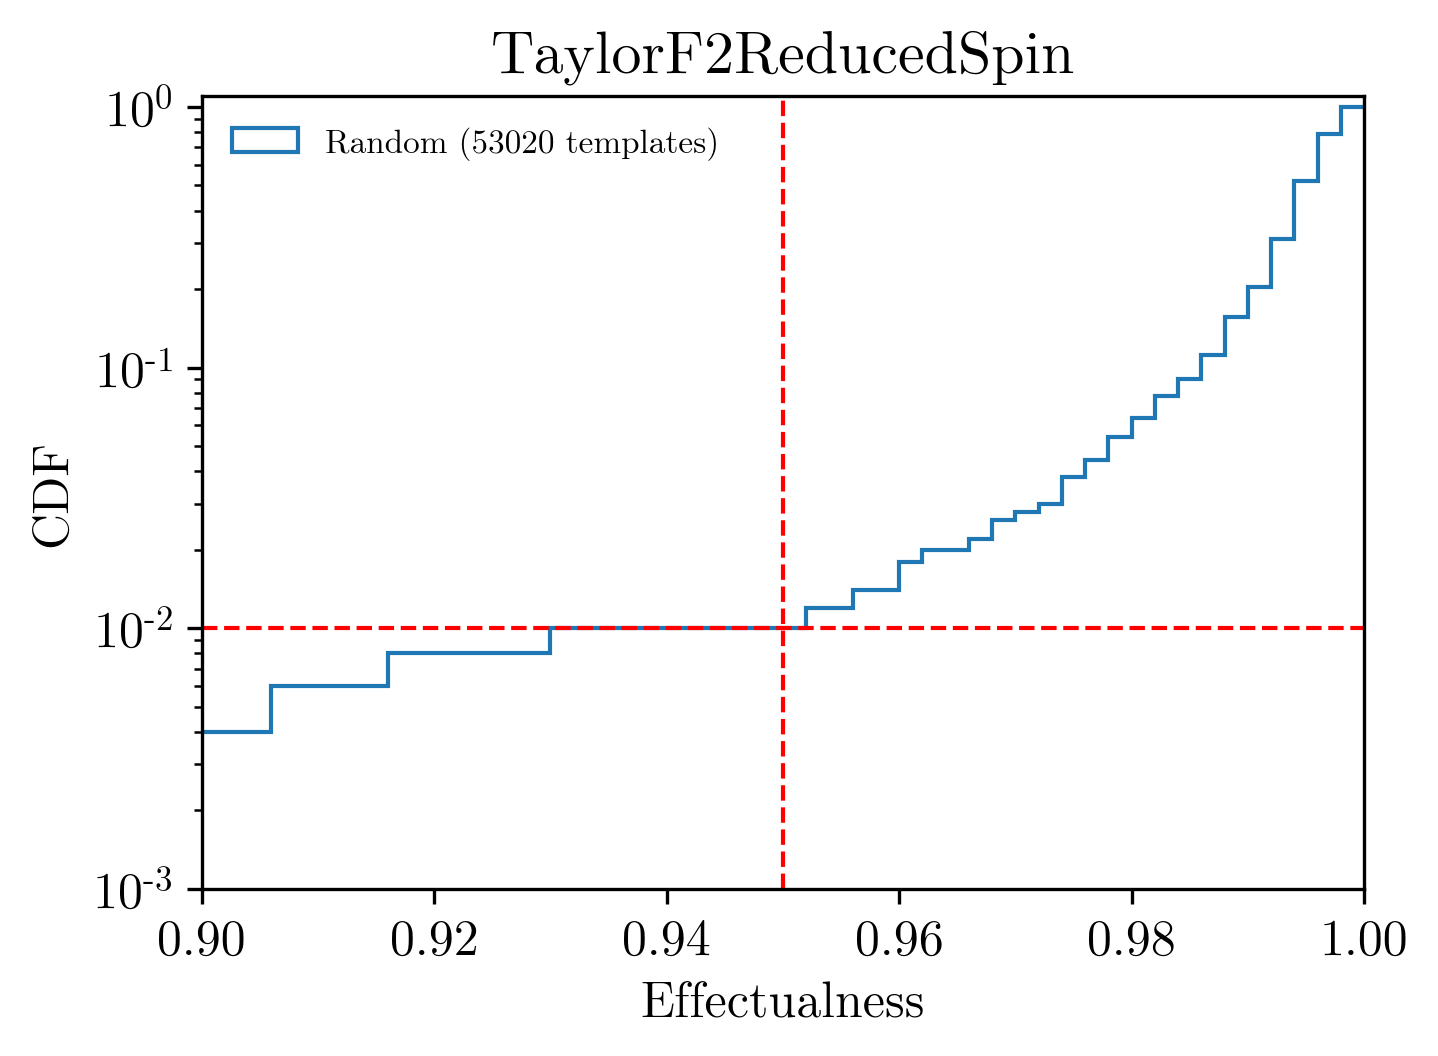

In [6]:
n_eff = len(bank_r.effectualnesses)
bins = jnp.concatenate(
    (jnp.array([0.0]), jnp.linspace(0.9, 1, int(0.1 * n_eff + 1)), jnp.array([jnp.inf]))
)
plt.hist(
    bank_r.effectualnesses,
    bins=bins,
    density=True,
    cumulative=True,
    histtype="step",
    label=f"Random ({bank_r.n_templates} templates)",
)
# plt.hist(
#     bank_s.effectualnesses,
#     bins=bins,
#     range=(0, 1),
#     density=True,
#     cumulative=True,
#     histtype="step",
#     label=f"Stochastic ({bank_s.n_templates} templates)",
# )
plt.axvline(1 - m_star, color="r", linestyle="--", linewidth=1)
plt.axhline(1 - eta_star, color="r", linestyle="--", linewidth=1)
plt.axhline(5)
plt.axhline(4)
plt.legend(loc="upper left", frameon=False, fontsize=8)
plt.xlim(bins[1], 1)
plt.ylim(0.5 / n_eff, 1.1)
plt.yscale("log")
plt.xlabel("Effectualness")
plt.ylabel("CDF")
plt.title("TaylorF2ReducedSpin")